In [1]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", False)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import models
import flows

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# set up exporting
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': False,
    'pgf.rcfonts': False,
})

figure_path = "/home/lauro/documents/msc-thesis/thesis/figures/"
# save figures by using plt.savefig('title of figure')
# remember that latex textwidth is 5.4in
# so use figsize=[5.4, 4], for example

In [3]:
def plot_samples(target_pdf, sample_list, lims=(-4, 4)):
    """sample_list: iterable of sets of samples"""
    fig, axs = plt.subplots(1, 3, figsize=[30, 9])
    titles = ("Neural SVGD", "SVGD", "True samples")
    for ax, samples, title in zip(axs.flatten(), sample_list, titles):
        ax.set(xlim=lims, ylim=lims)
        plot.plot_fun_2d(target_pdf, lims=lims, ax=ax, alpha=0.5)
#         plot.plot_gradient_field(utils.negative(neural_learner.grads), ax, lims=lims)
        plot.scatter(samples, ax=ax)
        ax.set_title(title)


def animate(target_pdf, traj_list, lims=(-4, 4), interval=100):
    """Remember to activate %matplotlib widget"""
    n = len(traj_list)
    fig, axs = plt.subplots(1, n, figsize=[6*n, 5])
    titles = ("Neural SVGD", "SVGD")
    anims = []
    for ax, traj, title in zip(axs.flatten(), traj_list, titles):
        ax.set(xlim=lims, ylim=lims)
        plot.plot_fun_2d(target.pdf, lims=lims, ax=ax, alpha=0.5)
        anims.append(plot.animate_array(traj, fig, ax, interval=interval))
    return anims, fig, axs

In [4]:
neural_trajectories = []
svgd_trajectories = []

# Squiggle

In [60]:
setup = distributions.squiggle_target
target, proposal = setup.get()

In [11]:
n_steps = 200
n_particles = 100

particle_lr = 1e-2
learner_lr = 2e-3

key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., patience=10, learner_lr=learner_lr, aux=False)
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

100%|██████████| 200/200 [00:01<00:00, 124.49it/s]


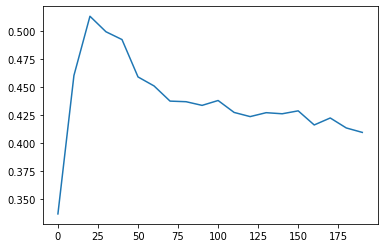

In [21]:
plt.plot(*zip(*neural_particles.rundata["mmd"]))

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:201: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, cmap=cmap, **kwargs)


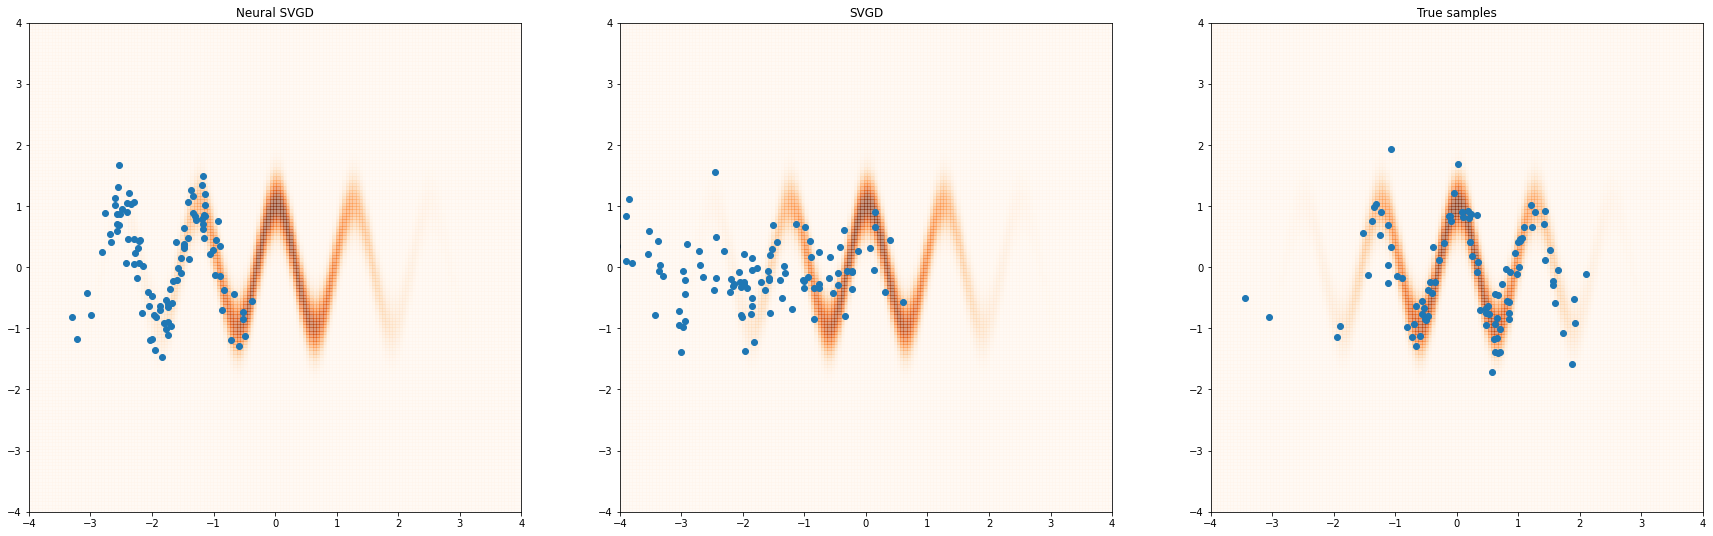

In [13]:
%matplotlib inline
sample_list = [p.particles.training for p in (neural_particles, svgd_particles)] + [target.sample(n_particles)]
plot_samples(target.pdf, sample_list)

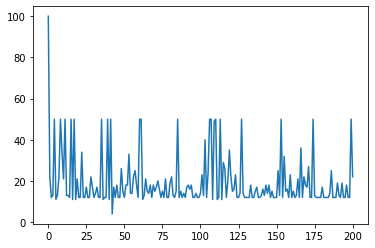

In [14]:
%matplotlib inline
plt.plot(neural_learner.rundata["train_steps"])

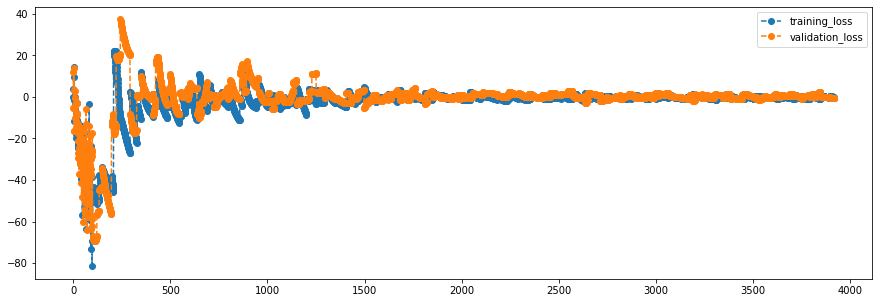

In [15]:
%matplotlib inline
plt.subplots(figsize=[15, 5])
for loss, label in [(neural_learner.rundata[k], k) for k in ("training_loss", "validation_loss")]:
    plt.plot(loss, "--o", label=label)
    
plt.legend()

#### animation

In [16]:
neural_trajectories = {}
svgd_trajectories = {}

In [17]:
neural_trajectories["squiggle"] = neural_particles.rundata["particles"].training
svgd_trajectories["squiggle"]   = svgd_particles.rundata["particles"].training

In [18]:
testt = neural_particles.rundata["particles"].training

In [61]:
i = 0
traj, traj_svgd = [d["squiggle"] for d in (neural_trajectories, svgd_trajectories)]
%matplotlib widget
lims=(-4, 4)
ans, fig, axs = animate(target.pdf, [traj, traj_svgd], lims=lims, interval=100)
# ans.append(plot.animate_array(testt, fig, axs[0]))
ans

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:201: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, cmap=cmap, **kwargs)


# Mixture

In [20]:
setup = distributions.mix_of_gauss
target, proposal = setup.get()

In [22]:
n_steps = 500
# particle_lr = 1e-2
# learner_lr = 1e-1

key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., patience=10, learner_lr=learner_lr)
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

100%|██████████| 500/500 [00:04<00:00, 113.21it/s]


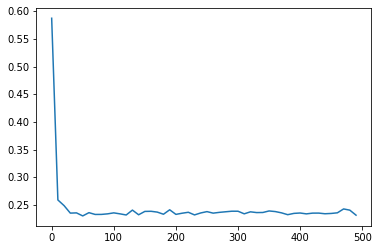

In [23]:
plt.plot(*zip(*neural_particles.rundata["mmd"]))

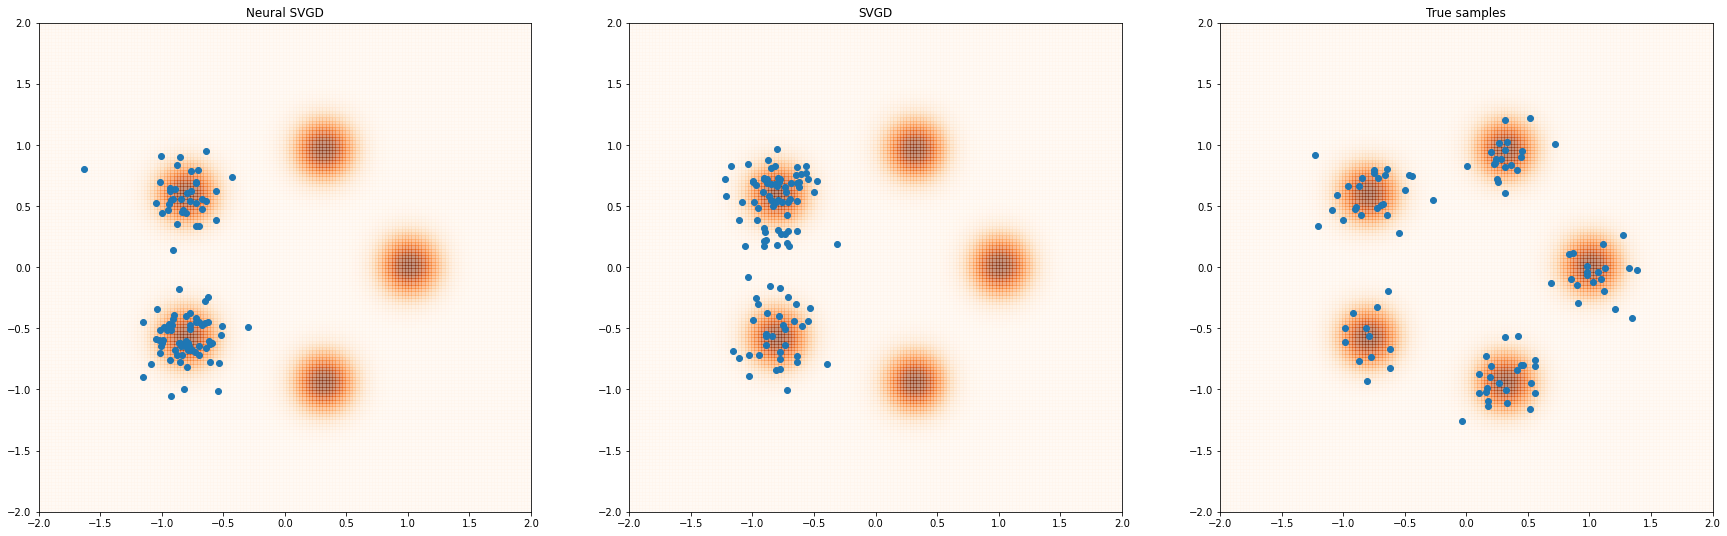

In [24]:
%matplotlib inline
mix_lims = (-2, 2)
sample_list = [p.particles.training for p in (neural_particles, svgd_particles)] + [target.sample(n_particles)]
plot_samples(target.pdf, sample_list, mix_lims)

In [25]:
neural_trajectories["mix"] = neural_particles.rundata["particles"].training
svgd_trajectories["mix"]   = svgd_particles.rundata["particles"].training

# Mixture, initialized in the middle

In [26]:
target, proposal = distributions.mix_of_gauss.get()
proposal = distributions.Gaussian([0, 0], [1, 1])
setup = distributions.Setup(target, proposal)

In [27]:
n_steps = 300
# particle_lr = 1e-2
# learner_lr = 1e-1

key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., patience=10, learner_lr=learner_lr)
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

100%|██████████| 300/300 [00:03<00:00, 81.13it/s]


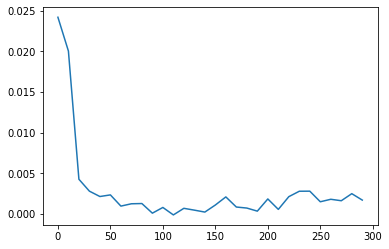

In [28]:
plt.plot(*zip(*neural_particles.rundata["mmd"]))

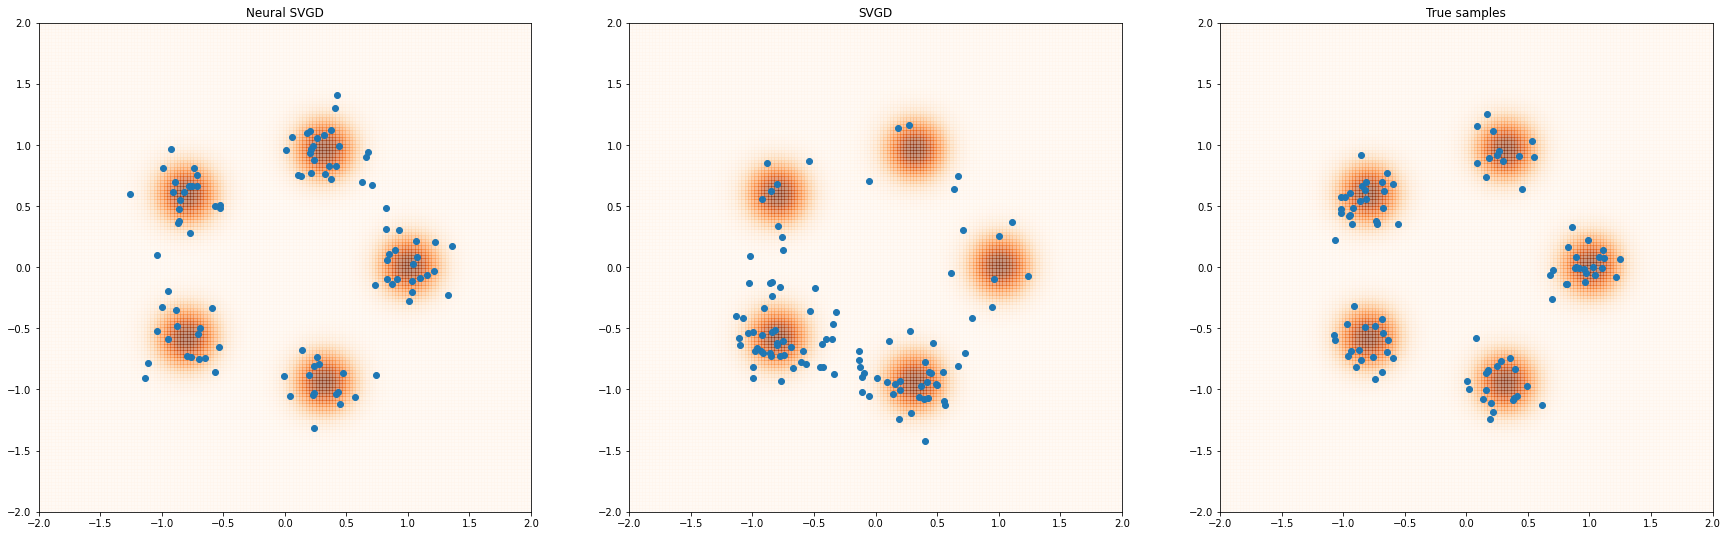

In [29]:
%matplotlib inline
sample_list = [p.particles.training for p in (neural_particles, svgd_particles)] + [target.sample(n_particles)]
plot_samples(target.pdf, sample_list, mix_lims)

# Circle

In [30]:
setup = distributions.ring_target
target, proposal = setup.get()

In [31]:
n_steps = 300
# n_particles = 300
# particle_lr = 1e-2
# learner_lr = 1e-1

key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., patience=10, learner_lr=learner_lr)
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=1.)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

100%|██████████| 300/300 [00:03<00:00, 83.94it/s]


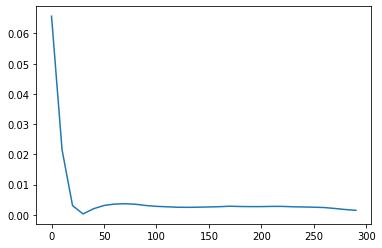

In [32]:
plt.plot(*zip(*neural_particles.rundata["mmd"]))

In [33]:
neural_trajectories["circle"] = neural_particles.rundata["particles"].training
svgd_trajectories["circle"]   = svgd_particles.rundata["particles"].training

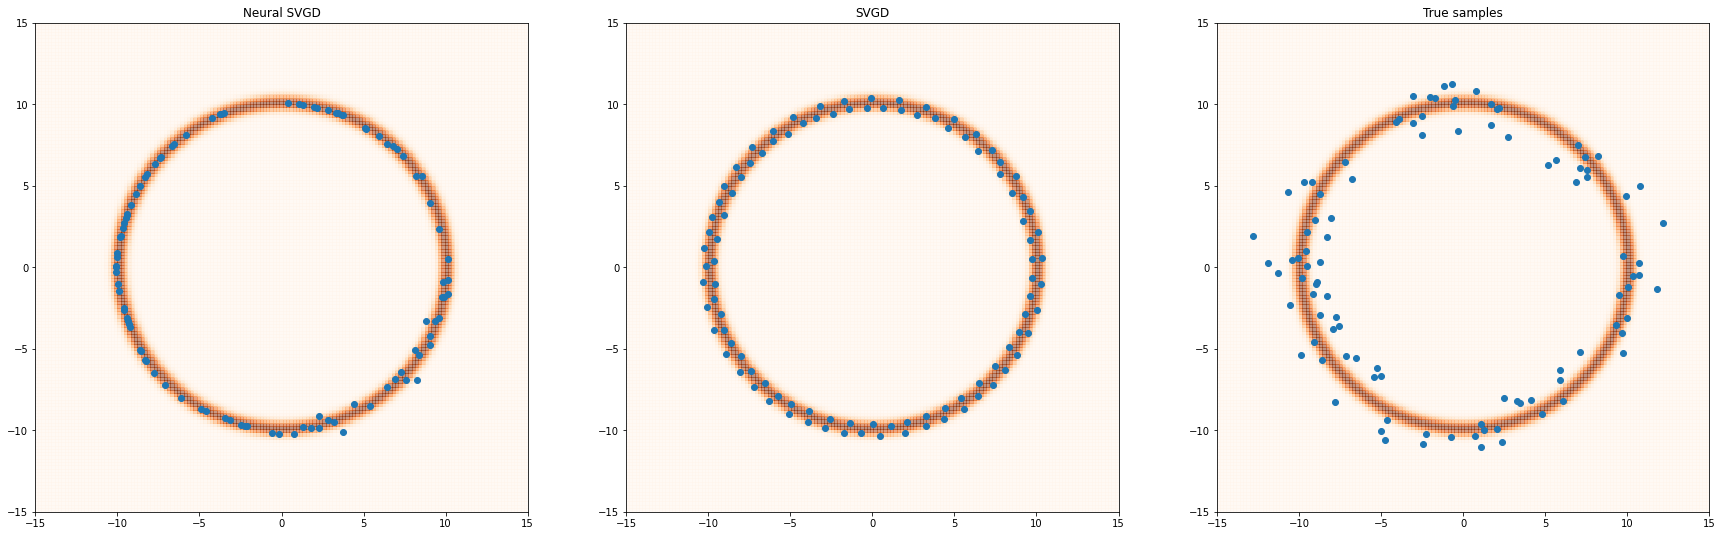

In [34]:
sample_list = [p.particles.training for p in (neural_particles, svgd_particles)] + [target.sample(n_particles)]
plot_samples(target.pdf, sample_list, (-15, 15))

# Funnel

In [65]:
setup = distributions.funnel
target, proposal = setup.get()

In [36]:
%autoreload

In [67]:
# n_steps = 500
n_particles = 300
particle_lr = 1e-2
learner_lr = 1e-1

key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., patience=10, learner_lr=learner_lr, aux=False)
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

100%|██████████| 800/800 [00:06<00:00, 132.84it/s]


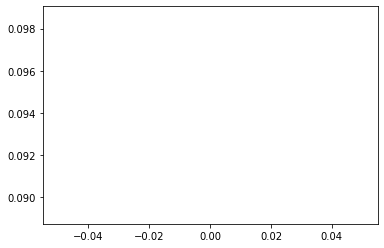

In [68]:
%matplotlib inline
plt.plot(*zip(*neural_particles.rundata["mmd"]))

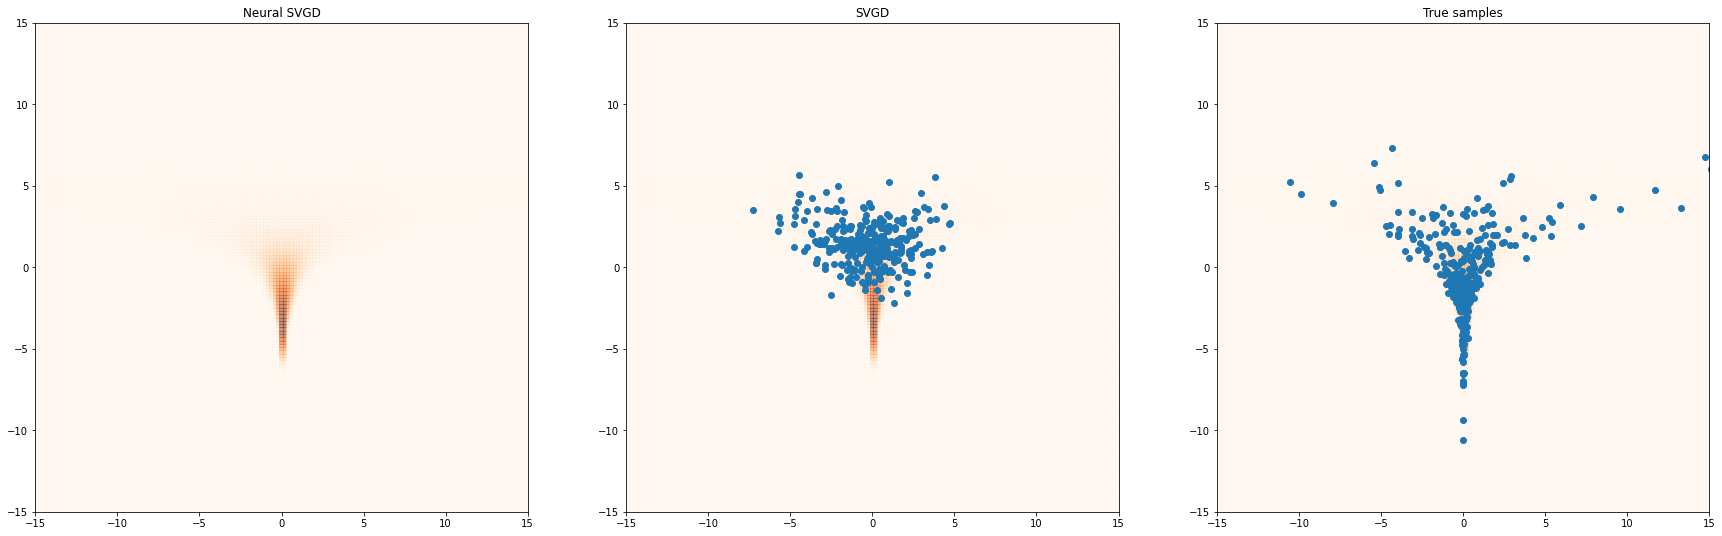

In [69]:
%matplotlib inline
sample_list = [p.particles.training for p in (neural_particles, svgd_particles)] + [target.sample(n_particles)]
funnel_lims=(-15, 15)
plot_samples(target.pdf, sample_list, funnel_lims)

In [70]:
neural_trajectories["funnel"] = neural_particles.rundata["particles"].training
svgd_trajectories["funnel"]   = svgd_particles.rundata["particles"].training

In [71]:
# step size too large?????

In [72]:
# i = 3
# traj, traj_svgd = [d["funnel"] for d in (neural_trajectories, svgd_trajectories)]
# %matplotlib widget
# animate(target.pdf, [traj, traj_svgd], lims=funnel_lims, interval=10)

# Banana

In [73]:
setup = distributions.banana_target
target, proposal = setup.get()

In [75]:
n_steps = 800
# n_particles = 300
# particle_lr = 1e-2
# learner_lr = 1e-1

key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., patience=10, learner_lr=learner_lr)
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

100%|██████████| 800/800 [00:06<00:00, 125.32it/s]


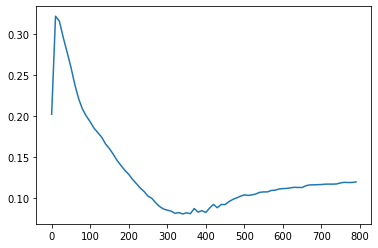

In [76]:
plt.plot(*zip(*neural_particles.rundata["mmd"]))

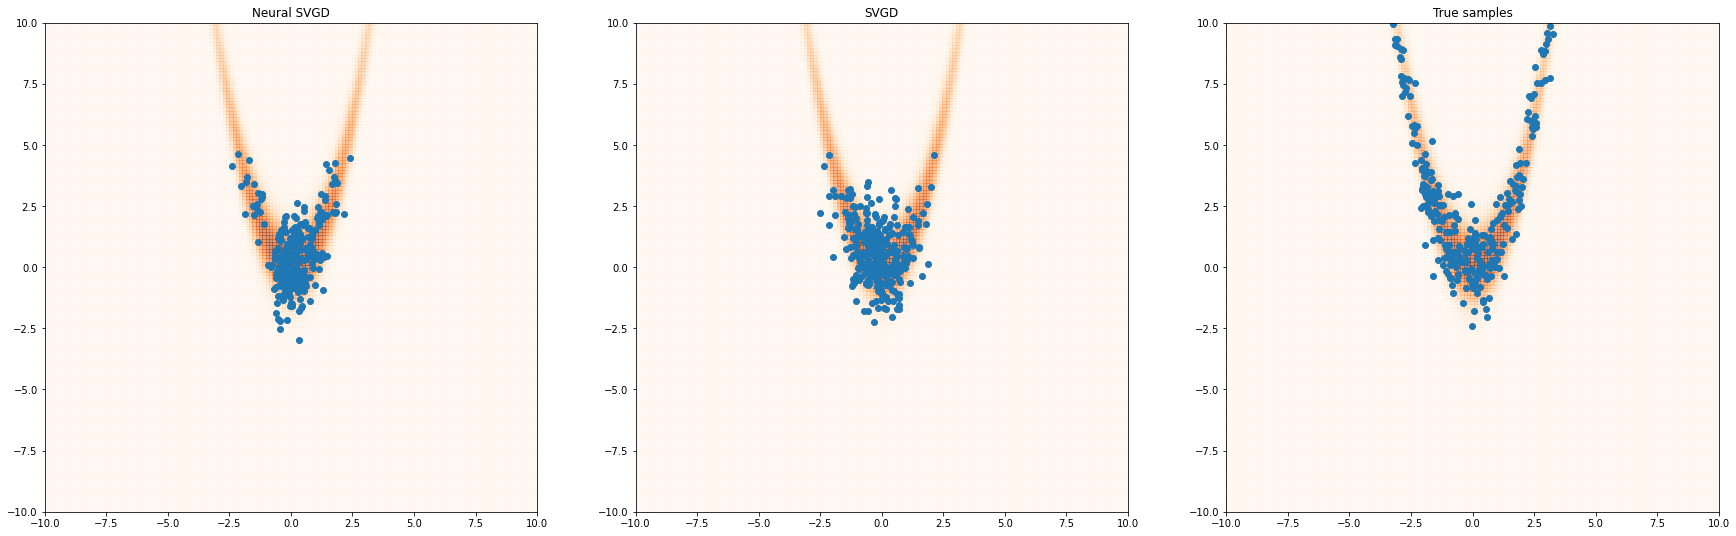

In [77]:
%matplotlib inline
banana_lims=(-10, 10)
sample_list = [p.particles.training for p in (neural_particles, svgd_particles)] + [target.sample(n_particles)]
plot_samples(target.pdf, sample_list, banana_lims)

In [78]:
neural_trajectories["banana"] = neural_particles.rundata["particles"].training
svgd_trajectories["banana"]   = svgd_particles.rundata["particles"].training

In [79]:
# i = 4
# traj, traj_svgd = [lst[i] for lst in (neural_trajectories, svgd_trajectories)]
# %matplotlib widget
# animate(target.pdf, [traj, traj_svgd], lims=banana_lims, interval=10)

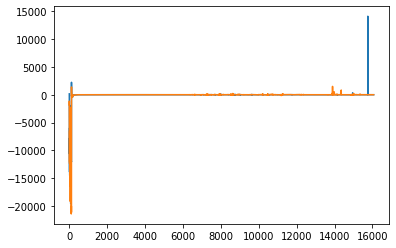

In [80]:
# %matplotlib widget
plt.plot(neural_learner.rundata["training_loss"])
plt.plot(neural_learner.rundata["validation_loss"])